In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import glob
import itertools

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac

In [2]:
from monk import nb, prep, pair, render, utils, grid
import freud

In [3]:
class VerifyEquilibrium(hoomd.custom.Action):
    """Computes dynamics to verify equilibration."""

    def __init__(self, k: float = None):
        self.last_pos = None
        self.last_image = None
        self.last_tstep = None
        self.k = 7.14
        self.alphas = []
        self.Ds = []
        self.msds = []
        self.sisfs = []
        self.tsteps = []
    
    def act(self, timestep):
        
        if self.last_pos is None:
            snap = self._state.get_snapshot()
            self.last_pos = snap.particles.position
            self.last_image = snap.particles.image
            self.first_tstep = timestep
            self.last_tstep = timestep
            self.last_msd = 0.0
            self.alpha_time = 0.0
            self.measure_D = False
            self.measured_D = 0.0
            self.measured_alpha = 0.0
        else:
            if self.measure_D:
                dt = self._state._simulation.operations.integrator.dt
                if (timestep - self.last_tstep)*dt > self.measured_alpha:
                    snap = self._state.get_snapshot()
                    pos = snap.particles.position
                    image = snap.particles.image
                    sim_box = self._state.box
                    if sim_box.is2D:
                        dim = 2
                    else:
                        dim = 3
                    box = freud.box.Box.from_box(sim_box)
                    unwrapped_pos = box.unwrap(pos, image - self.last_image)
                    msd = np.mean(np.sum(np.square(unwrapped_pos - self.last_pos), axis=-1))
                    self.msds.append(msd)
                    self.tsteps.append(timestep - self.first_tstep)
                    D = (msd - self.last_msd) / (timestep - self.last_tstep) / dt / (2 * dim)
                    self.measured_D = D
                    self.Ds.append(self.measured_D)
                    self.alphas.append(self.measured_alpha)
                    self.measure_D = False
                    self.alpha_time = 0.0
                    self.first_tstep = timestep
                    self.last_pos = snap.particles.position
                    self.last_image = snap.particles.image
            else:
                snap = self._state.get_snapshot()
                dt = self._state._simulation.operations.integrator.dt
                pos = snap.particles.position
                image = snap.particles.image
                sim_box = self._state.box
                if sim_box.is2D:
                    dim = 2
                else:
                    dim = 3
                box = freud.box.Box.from_box(sim_box)
                unwrapped_pos = box.unwrap(pos, image - self.last_image)
                msd = np.mean(np.sum(np.square(unwrapped_pos - self.last_pos), axis=-1))
                self.msds.append(msd)
                self.tsteps.append(timestep - self.first_tstep)
                self.last_tstep = timestep
                self.last_msd = msd
                

                x = self.k * np.linalg.norm(pos - self.last_pos, axis=-1)
                sisf = np.mean(np.sin(x)/x)
                self.sisfs.append(sisf)

                # print(f"{D} {sisf}")

                self.alpha_time = (timestep - self.first_tstep) * dt
                if sisf < np.exp(-1.0):
                    self.measure_D = True
                    self.measured_alpha = self.alpha_time

In [4]:
project: signac.Project = signac.init_project("mlj-equilibration")

In [16]:
project.doc["threshold_alpha"] = 1000.0  # when to stop equilibration
project.doc["temp_step"] = 0.1  # temperature step size
project.doc["alpha_iters"] = 10  # number of times to measure alpha before moving to next temperature point
project.doc["equil_steps"] = 40_000  # number of steps to equilibrate before measuring tau_alpha

In [5]:
project.doc

{'threshold_alpha': 1000.0, 'temp_step': 0.1, 'alpha_iters': 10, 'equil_steps': 40000}

In [19]:
gridspec = {
    'delta-phi-temp': zip(
        [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        [1.2, 1.18, 1.16, 1.14, 1.12, 1.1],
        [2.0, 2.6, 3.2, 3.8, 4.4, 5.0]
    )
}

N = 2**15

sps = list(grid(gridspec))

In [20]:
len(sps)

6

In [21]:
i = 0
for _replica in range(3):
    for grid_sp in sps:
        sp = {"N": N, "seed": i}
        delta_phi_temp = grid_sp['delta-phi-temp']
        sp.update({"delta": delta_phi_temp[0], "phi": delta_phi_temp[1], "temp": delta_phi_temp[2]})
        job = project.open_job(sp)
        job.init()
        print(sp)
        i += 1

{'N': 32768, 'seed': 0, 'delta': 0.0, 'phi': 1.2, 'temp': 2.0}
{'N': 32768, 'seed': 1, 'delta': 0.1, 'phi': 1.18, 'temp': 2.6}
{'N': 32768, 'seed': 2, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
{'N': 32768, 'seed': 3, 'delta': 0.3, 'phi': 1.14, 'temp': 3.8}
{'N': 32768, 'seed': 4, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
{'N': 32768, 'seed': 5, 'delta': 0.5, 'phi': 1.1, 'temp': 5.0}
{'N': 32768, 'seed': 6, 'delta': 0.0, 'phi': 1.2, 'temp': 2.0}
{'N': 32768, 'seed': 7, 'delta': 0.1, 'phi': 1.18, 'temp': 2.6}
{'N': 32768, 'seed': 8, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
{'N': 32768, 'seed': 9, 'delta': 0.3, 'phi': 1.14, 'temp': 3.8}
{'N': 32768, 'seed': 10, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
{'N': 32768, 'seed': 11, 'delta': 0.5, 'phi': 1.1, 'temp': 5.0}
{'N': 32768, 'seed': 12, 'delta': 0.0, 'phi': 1.2, 'temp': 2.0}
{'N': 32768, 'seed': 13, 'delta': 0.1, 'phi': 1.18, 'temp': 2.6}
{'N': 32768, 'seed': 14, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
{'N': 32768, 'seed': 15, 'delta': 0.3, '

In [5]:
project.num_jobs()

18

In [8]:
import math
def roundup(x):
    return 10**math.ceil(math.log10(x))

In [8]:
for job in project:
    assert isinstance(job, signac.Project.Job)
    print("SP:", job.sp)
    sp = job.sp

    alpha_thresh = project.doc["threshold_alpha"]
    temp_step = project.doc["temp_step"]
    alpha_iters = project.doc["alpha_iters"]
    equil_steps = project.doc["equil_steps"]

    run_duration = 100_000

    if len(glob.glob(job.fn("not-equil_*.gsd"))) > 0:
        print(f"Job already reached threshold")
        continue

    already_done = sorted(glob.glob(job.fn("equil_*.gsd")))
    if len(already_done) > 0:
        state = already_done[0]
        print(f"Resuming from a checkpoint: {state.split('/')[-1]}")
        sim = hoomd.Simulation(hoomd.device.GPU(), seed=sp["seed"]+1)
        sim.create_state_from_gsd(state)

        integrator = hoomd.md.Integrator(dt=0.001)
        tree = hoomd.md.nlist.Tree(0.3)
        mlj = pair.KA_ModLJ(tree, sp["delta"])

        temp = state.split("equil_")[-1].split(".gsd")[0]

        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), float(temp) - temp_step, 0.1)
        integrator.forces = [mlj]
        integrator.methods = [nvt]

        sim.operations.integrator = integrator

        temp_gsd = temp.replace(".", "_")
        
        with job.data:
            max_alpha_steps = roundup(int(np.max(job.data[f"{temp_gsd}/alphas"][:])*1000))
        if max_alpha_steps > run_duration:
            run_duration = max_alpha_steps
    else:
        print("Initializing new state")
        sim = prep.quick_sim(sp["N"], sp["phi"], hoomd.device.GPU(), ratios=[80, 20], diams=[1.0, 0.88], seed=sp["seed"])

        integrator = hoomd.md.Integrator(dt=0.001)
        tree = hoomd.md.nlist.Tree(0.3)
        mlj = pair.KA_ModLJ(tree, sp["delta"])

        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), sp["temp"], 0.1)
        integrator.forces = [mlj]
        integrator.methods = [nvt]

        sim.operations.integrator = integrator
        
        sim.state.thermalize_particle_momenta(hoomd.filter.All(), sp["temp"])

        sim.run(0)
        nvt.thermalize_thermostat_dof()
        
        hoomd.write.GSD.write(sim.state, job.fn("init.gsd"))

    alpha_thresh_met = False
    while not alpha_thresh_met:

        print(f"temp: {nvt.kT(sim.timestep):.1f}", end="")

        sim.run(equil_steps)

        action = VerifyEquilibrium()
        custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(run_duration//1_000), action)
        sim.operations.updaters.clear()
        sim.operations.updaters.append(custom_action)

        while len(action.alphas) < alpha_iters:
            sim.run(run_duration)
            if (len(action.alphas) > 0 and np.max(action.alphas) > alpha_thresh) or action.alpha_time > alpha_thresh:
                alpha_thresh_met = True
                break
            
        cur_temp = nvt.kT(sim.timestep)
        job.data[f"{cur_temp:.1f}/tsteps".replace(".", "_")] = np.array(action.tsteps)
        job.data[f"{cur_temp:.1f}/msds".replace(".", "_")] = np.array(action.msds)
        job.data[f"{cur_temp:.1f}/sisfs".replace(".", "_")] = np.array(action.sisfs)
        job.data[f"{cur_temp:.1f}/alphas".replace(".", "_")] = np.array(action.alphas)
        job.data[f"{cur_temp:.1f}/Ds".replace(".", "_")] = np.array(action.Ds)
        if alpha_thresh_met:
            print(" ALPHA THRESHOLD MET")
            hoomd.write.GSD.write(sim.state, job.fn(f"not-equil_{cur_temp:.1f}.gsd"))
        else:
            print(f" alpha: {np.max(action.alphas):.2f} run_duration: {run_duration}")
            max_alpha_steps = roundup(int(np.max(action.alphas)*1000))
            if max_alpha_steps > run_duration:
                run_duration = max_alpha_steps
            hoomd.write.GSD.write(sim.state, job.fn(f"equil_{cur_temp:.1f}.gsd"))

        nvt.kT = cur_temp - temp_step

    del sim

SP: {'N': 32768, 'seed': 12, 'delta': 0.0, 'phi': 1.2, 'temp': 2.0}
Job already reached threshold
SP: {'N': 32768, 'seed': 13, 'delta': 0.1, 'phi': 1.18, 'temp': 2.6}
Job already reached threshold
SP: {'N': 32768, 'seed': 8, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
Job already reached threshold
SP: {'N': 32768, 'seed': 3, 'delta': 0.3, 'phi': 1.14, 'temp': 3.8}
Job already reached threshold
SP: {'N': 32768, 'seed': 1, 'delta': 0.1, 'phi': 1.18, 'temp': 2.6}
Job already reached threshold
SP: {'N': 32768, 'seed': 9, 'delta': 0.3, 'phi': 1.14, 'temp': 3.8}
Job already reached threshold
SP: {'N': 32768, 'seed': 10, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
Job already reached threshold
SP: {'N': 32768, 'seed': 4, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
Job already reached threshold
SP: {'N': 32768, 'seed': 6, 'delta': 0.0, 'phi': 1.2, 'temp': 2.0}
Job already reached threshold
SP: {'N': 32768, 'seed': 2, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
Job already reached threshold
SP: {'N': 32768, 's

In [9]:
for delta, group in project.groupby("delta"):

    group1, group2 = itertools.tee(group)

    temps = []
    for job in group1:
        with job:
            last_sim = sorted(glob.glob("not-equil_*.gsd"))[0]  # get lowest temp sim
            temp = utils.extract_between(last_sim, "not-equil_", ".gsd")
            temps.append(float(temp))  # add temp to list
    print(f"{delta:.1f}: {np.unique(temps)}")
    min_temp = np.min(temps)  # get min temp from sims of same delta

    # restart jobs that didn't reach the same end temperature at the same delta
    for job in group2:
        assert isinstance(job, signac.Project.Job)
        with job:
            last_sim = sorted(glob.glob("not-equil_*.gsd"))[0]
            temp = utils.extract_between(last_sim, "not-equil_", ".gsd")
            temps.append(float(temp))
            if np.isclose(float(temp), min_temp):  # if temp == min_temp, continue to next job
                print(temp, "No need to restart")
                continue
            else:
                print(temp, "Restarting")

        print("SP:", job.sp)
        sp = job.sp

        alpha_thresh = project.doc["threshold_alpha"]
        temp_step = project.doc["temp_step"]
        alpha_iters = project.doc["alpha_iters"]
        equil_steps = project.doc["equil_steps"]

        run_duration = 100_000  # default run duration

        # restart from the last complete simulation run
        already_done = sorted(glob.glob(job.fn("equil_*.gsd")))
        state = already_done[0]
        print(f"Resuming from a checkpoint: {state.split('/')[-1]}")
        sim = hoomd.Simulation(hoomd.device.GPU(), seed=sp["seed"]+1)
        sim.create_state_from_gsd(state)

        integrator = hoomd.md.Integrator(dt=0.001)
        tree = hoomd.md.nlist.Tree(0.3)
        mlj = pair.KA_ModLJ(tree, sp["delta"])

        temp = state.split("equil_")[-1].split(".gsd")[0]

        nvt = hoomd.md.methods.NVT(hoomd.filter.All(), float(temp) - temp_step, 0.1)
        integrator.forces = [mlj]
        integrator.methods = [nvt]

        sim.operations.integrator = integrator

        temp_gsd = temp.replace(".", "_")
        
        with job.data:
            max_alpha_steps = roundup(int(np.max(job.data[f"{temp_gsd}/alphas"][:])*1000))
        if max_alpha_steps > run_duration:
            run_duration = max_alpha_steps

        # implement approximate greater than
        while nvt.kT(sim.timestep) - min_temp > 1e-5:

            print(f"temp: {nvt.kT(sim.timestep):.1f}", end="")

            sim.run(equil_steps)

            action = VerifyEquilibrium()
            custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(run_duration//1_000), action)
            sim.operations.updaters.clear()
            sim.operations.updaters.append(custom_action)

            while len(action.alphas) < alpha_iters:
                sim.run(run_duration)
                
            cur_temp = nvt.kT(sim.timestep)
            job.data[f"rs-{cur_temp:.1f}/tsteps".replace(".", "_")] = np.array(action.tsteps)
            job.data[f"rs-{cur_temp:.1f}/msds".replace(".", "_")] = np.array(action.msds)
            job.data[f"rs-{cur_temp:.1f}/sisfs".replace(".", "_")] = np.array(action.sisfs)
            job.data[f"rs-{cur_temp:.1f}/alphas".replace(".", "_")] = np.array(action.alphas)
            job.data[f"rs-{cur_temp:.1f}/Ds".replace(".", "_")] = np.array(action.Ds)

            print(f" alpha: {np.max(action.alphas):.2f} run_duration: {run_duration}")
            max_alpha_steps = roundup(int(np.max(action.alphas)*1000))
            if max_alpha_steps > run_duration:
                run_duration = max_alpha_steps
            hoomd.write.GSD.write(sim.state, job.fn(f"rs-equil_{cur_temp:.1f}.gsd"))

            nvt.kT = cur_temp - temp_step

        del sim



0.0: [0.4]
0.4 No need to restart
0.4 No need to restart
0.4 No need to restart
0.1: [0.5]
0.5 No need to restart
0.5 No need to restart
0.5 No need to restart
0.2: [0.6 0.7]
0.7 Restarting
SP: {'N': 32768, 'seed': 14, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
Resuming from a checkpoint: equil_0.8.gsd
temp: 0.7 alpha: 1092.60 run_duration: 100000
0.6 No need to restart
0.7 Restarting
SP: {'N': 32768, 'seed': 8, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
Resuming from a checkpoint: equil_0.8.gsd
temp: 0.7 alpha: 809.30 run_duration: 100000
0.3: [0.9]
0.9 No need to restart
0.9 No need to restart
0.9 No need to restart
0.4: [1.2 1.3]
1.3 Restarting
SP: {'N': 32768, 'seed': 4, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
Resuming from a checkpoint: equil_1.4.gsd
temp: 1.3 alpha: 921.00 run_duration: 1000000
1.3 Restarting
SP: {'N': 32768, 'seed': 10, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
Resuming from a checkpoint: equil_1.4.gsd
temp: 1.3 alpha: 926.00 run_duration: 1000000
1.2 No need to restart

{'N': 32768, 'seed': 3, 'delta': 0.3, 'phi': 1.14, 'temp': 3.8}
{'N': 32768, 'seed': 1, 'delta': 0.1, 'phi': 1.18, 'temp': 2.6}
{'N': 32768, 'seed': 4, 'delta': 0.4, 'phi': 1.12, 'temp': 4.4}
{'N': 32768, 'seed': 2, 'delta': 0.2, 'phi': 1.16, 'temp': 3.2}
{'N': 32768, 'seed': 5, 'delta': 0.5, 'phi': 1.1, 'temp': 5.0}
{'N': 32768, 'seed': 0, 'delta': 0.0, 'phi': 1.2, 'temp': 2.0}


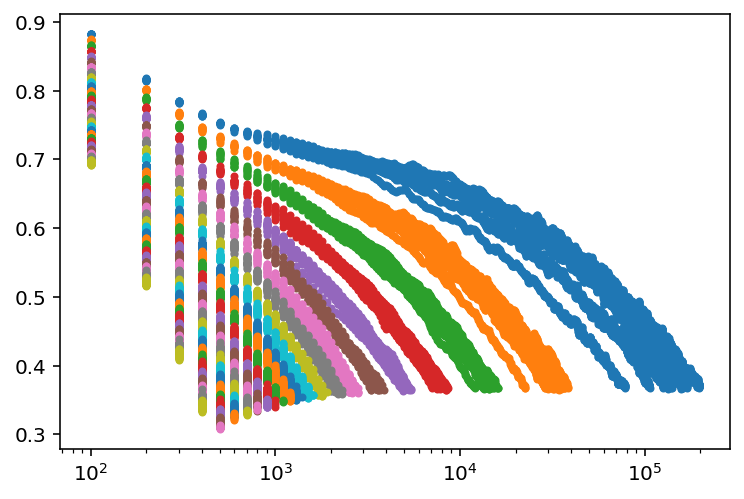

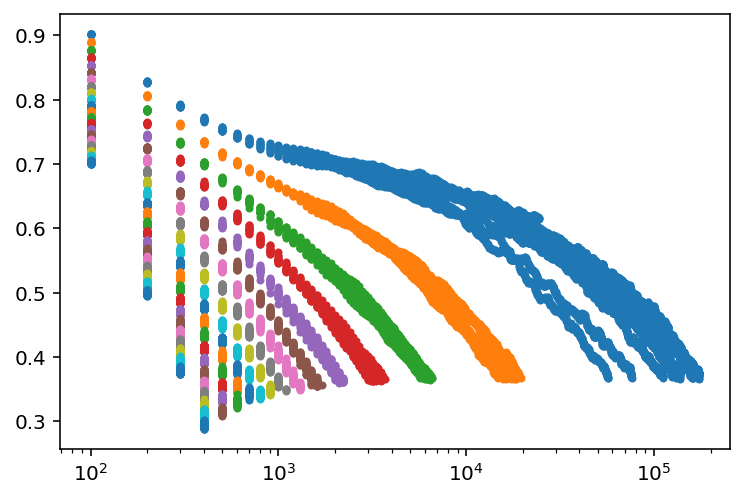

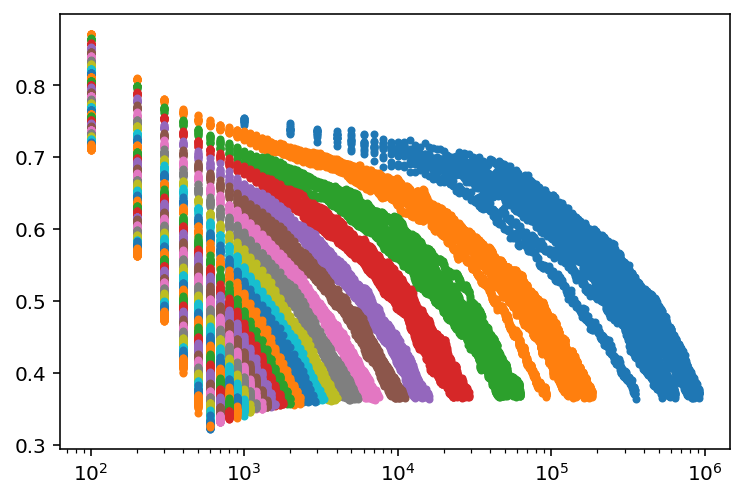

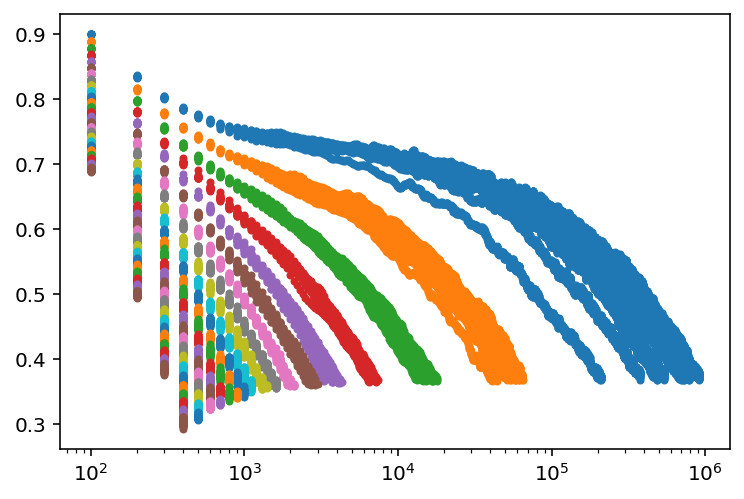

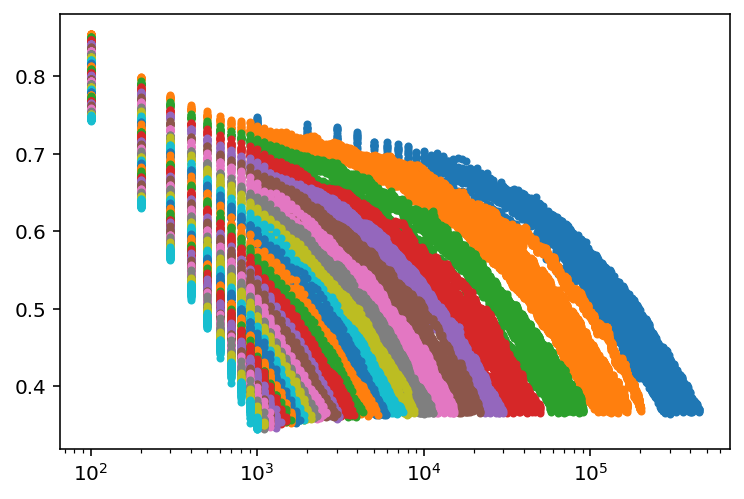

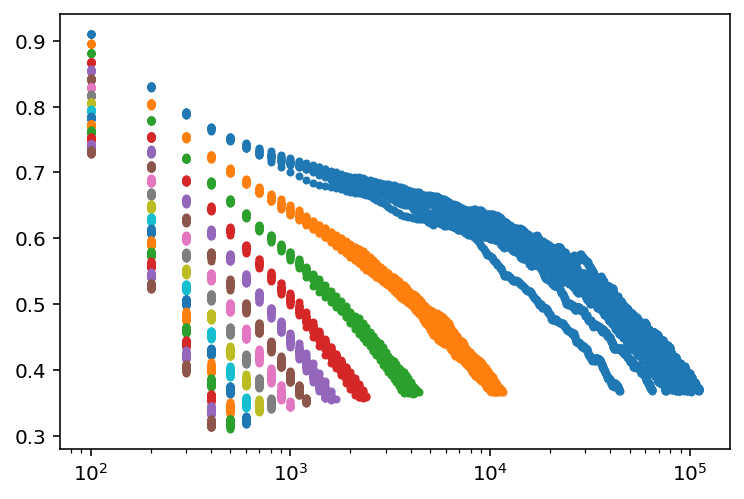

In [44]:
# aggregate job data

for job in project:

    if job.sp["seed"] > 5:
        continue

    print(job.sp)

    plt.figure()

    with job:
        sims = glob.glob("rs-equil_*.gsd") + sorted(glob.glob("equil_*.gsd"))

        for sim in sims:
            temp = utils.extract_between(sim, "equil_", ".gsd")
            _temp = temp.replace(".", "_")
            # print(temp)
            if "rs" in sim:
                pre = "rs-"
            else:
                pre = ""
            with job.data:
                time = list(job.data[f"{pre}{_temp}/tsteps"][:])
                for i in range(1, len(time)):
                    if i < len(time) and time[i] < time[i-1]:
                        del time[i-1]
                data = job.data[f"{pre}{_temp}/sisfs"][:]
                plt.plot(time[:len(data)], data, ".")
            # break
        
    # plt.yscale('log')
    plt.xscale('log')